In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:85% !important;}</style>"))

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging

from sklearn.datasets import make_classification

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
from ensemble_models.helpers import gen_samples, setup_logging, shift_features, psi

setup_logging()

In [4]:
data = gen_samples(n_samples = 20000)
data_raw = data.reset_index().rename(columns={"index":"time_col"})

2021-01-24 21:58:12 - INFO - gen_samples: Generating 5 exponential features with 20000 rows
2021-01-24 21:58:12 - INFO - gen_samples: Generating 5 uniform features with 20000 rows
2021-01-24 21:58:12 - INFO - gen_samples: Generating 5 normal features with 20000 rows


In [5]:
make_copy = lambda x: x.copy()

cols_to_shift = [
    col for col in data.columns
    if col.endswith("_2") or col.endswith("_3") or col.endswith("_4")
]
print(cols_to_shift)

exp_cols_to_shift = [col for col in cols_to_shift if 'exp' in col]
exp_uni_to_shift = [col for col in cols_to_shift if 'uni' in col]
exp_norm_to_shift = [col for col in cols_to_shift if 'norm' in col]


data = (
    data_raw
    .pipe(make_copy)
    .pipe(shift_features, cols_to_shift = data.columns, min_max_scaler_range=(1,100))
)

data_shift = (
    data_raw
    .pipe(make_copy)
    .pipe(shift_features, cols_to_shift = data.columns, min_max_scaler_range=(1,100))
    .pipe(shift_features, cols_to_shift = exp_cols_to_shift, min_max_scaler_range=(1,150))
        .pipe(shift_features, cols_to_shift = exp_uni_to_shift, min_max_scaler_range=(20,120))
        .pipe(shift_features, cols_to_shift = exp_norm_to_shift, min_max_scaler_range=(-50,150))
)

['col_exp_2', 'col_exp_3', 'col_exp_4', 'col_uni_2', 'col_uni_3', 'col_uni_4', 'col_norm_2', 'col_norm_3', 'col_norm_4']


In [6]:
data.columns

Index(['time_col', 'col_exp_0', 'col_exp_1', 'col_exp_2', 'col_exp_3',
       'col_exp_4', 'col_uni_0', 'col_uni_1', 'col_uni_2', 'col_uni_3',
       'col_uni_4', 'col_norm_0', 'col_norm_1', 'col_norm_2', 'col_norm_3',
       'col_norm_4'],
      dtype='object')

In [7]:
features = [col for col in data.columns if col.startswith("col_")]

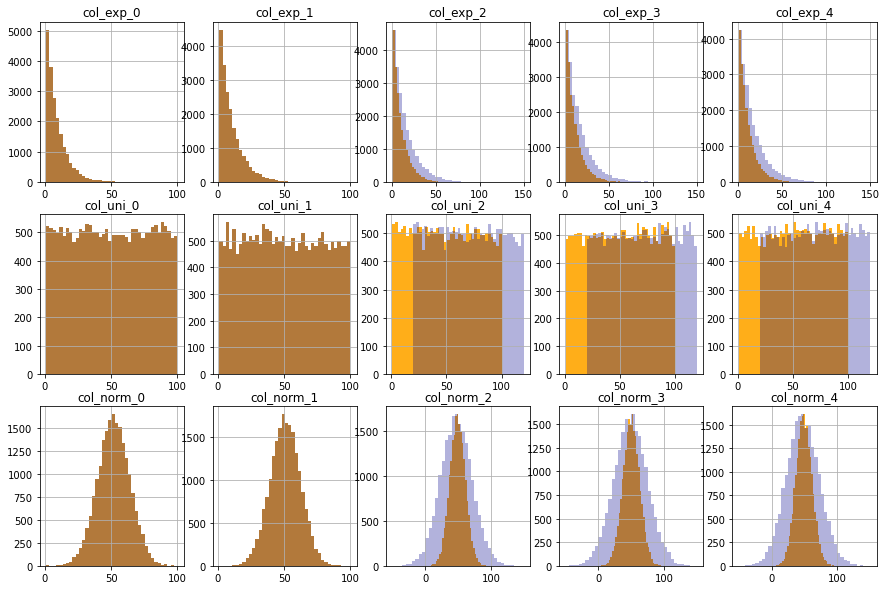

In [8]:
fig, ax = plt.subplots(3,5, figsize=(15,10))

for ix,col in enumerate([col for col in data.columns if "time" not in col]):
    ix_horiz = ix%5
    ix_vert = int(ix/5)                  
    data[col].hist(bins=40,alpha=0.9, ax = ax[ix_vert][ix_horiz],color='orange')
    data_shift[col].hist(bins=40,alpha=0.3, ax = ax[ix_vert][ix_horiz], color='darkblue')
    ax[ix_vert][ix_horiz].set_title(col)

### First simple scenario

Let's generate a time component to the defaults

In [9]:
from targen.data import target

In [10]:
# linear = "".join([
#     "-0.9*col_exp_0",
#     "+ 2.*col_exp_1",
# ])

In [11]:
interaction_terms = "".join([
    "2.5*col_exp_2*col_exp_3",
    "-0.2*col_uni_2*col_uni_3",
    "+0.7*col_norm_2*col_norm_3",
    
    "+0.8*col_norm_2*col_uni_3", #
    "-1.3*col_uni_2/col_exp_3", # the shift shoul reduce here the effect  
])

In [12]:
expressions = {
    'linear': '-0.9*col_exp_0 + 2.*col_exp_1 + 0.7*col_uni_0 - 0.4*col_uni_1 + 0.2*col_norm_0 - 0.4*col_norm_1  -0.3*time_col',
    
    'non_linear': '-0.7*col_exp_3**1.5 + 0.2*sin(col_norm_3)+ 0.9*log(col_norm_4) -0.1*col_uni_4**2',
   'interaction': interaction_terms,
    'conditional': {
        'col_uni_4>0':(
            '-0.5*col_exp_0 + 2.*col_uni_4 + 0.7*col_norm_3 -0.4*col_exp_1', #True
            0 #False
        ),
        'col_uni_3>0.15':(
            '-0.5*col_norm_0 + 2.*col_uni_4 + 0.2*col_uni_3 -0.7*col_norm_2',#True
            '-0.5*col_exp_2' #False
        )
    },
    'uniform_noise': {
        'weight':5.5
    },
    'gaussian_noise': {
        'weight':4.4,
        'mu_gaus': 0
    }
}

In [13]:
# target.get_target_and_contributions?

In [14]:
data_y = target.get_target_and_contributions(data, expressions=expressions, imbalance = 0.1, drop_features=False)
data_y.columns

Index(['time_col', 'col_exp_0', 'col_exp_1', 'col_exp_2', 'col_exp_3',
       'col_exp_4', 'col_uni_0', 'col_uni_1', 'col_uni_2', 'col_uni_3',
       'col_uni_4', 'col_norm_0', 'col_norm_1', 'col_norm_2', 'col_norm_3',
       'col_norm_4', 'score_linear', 'score_non_linear', 'score_interaction',
       'score_conditional', 'score_uniform_noise', 'score_gaussian_noise',
       'score_total', 'y'],
      dtype='object')

In [15]:
data_y['y'].value_counts()

0    18000
1     2000
Name: y, dtype: int64

In [16]:
from sklearn.metrics import roc_auc_score

print(f"Linear component: {roc_auc_score(data_y['y'],data_y['score_linear'])}")
print(f"Non Linear component: {roc_auc_score(data_y['y'],data_y['score_non_linear'])}")
print(f"Interaction component: {roc_auc_score(data_y['y'],data_y['score_interaction'])}")
print(f"Conditional component: {roc_auc_score(data_y['y'],data_y['score_conditional'])}")
print(f"Total component: {roc_auc_score(data_y['y'],data_y['score_linear'] + data_y['score_non_linear'] + data_y['score_interaction'] + data_y['score_conditional'])}")
# print(f"Total component: {roc_auc_score(tmp['y'],tmp['score_linear'] + tmp['score_non_linear'] + tmp['score_interaction'])}")

Linear component: 0.5218691944444445
Non Linear component: 0.4689126944444445
Interaction component: 0.8429911111111111
Conditional component: 0.5448260555555555
Total component: 0.846809


(array([-2.,  0.,  2.,  4.,  6.,  8., 10.]),
 [Text(-2.0, 0, '(15999.2, 17999.1]'),
  Text(0.0, 0, '(-0.001, 1999.9]'),
  Text(2.0, 0, '(3999.8, 5999.7]'),
  Text(4.0, 0, '(7999.6, 9999.5]'),
  Text(6.0, 0, '(11999.4, 13999.3]'),
  Text(8.0, 0, '(15999.2, 17999.1]'),
  Text(10.0, 0, '')])

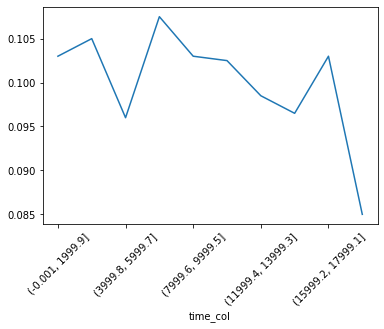

In [17]:
(
    data_y
    .groupby(pd.qcut(data_y['time_col'],q=10))
    ['y'].agg("mean")
    
).plot()
plt.xticks(rotation=45)

In [18]:
frac_it = 0.8

data_it = data_y.head(int(frac_it*data_y.shape[0]))
data_oot = data_y.tail(int((1-frac_it)*data_y.shape[0]+1))

In [19]:
# lgb.LGBMClassifier?

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[40]	training's auc: 0.854451	training's binary_logloss: 0.249051	valid_1's auc: 0.83673	valid_1's binary_logloss: 0.248471	valid_2's auc: 0.834574	valid_2's binary_logloss: 0.244585
CPU times: user 600 ms, sys: 28.4 ms, total: 629 ms
Wall time: 303 ms


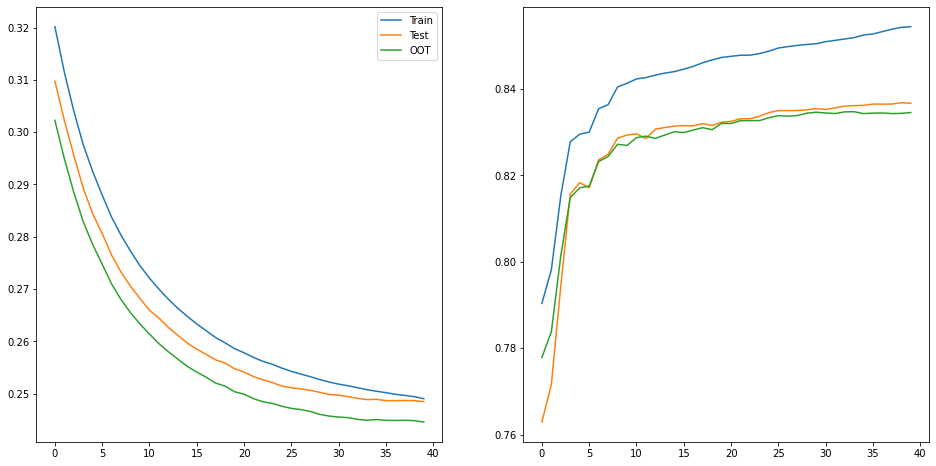

In [20]:
%%time

X_train, X_test, y_train, y_test = train_test_split(data_it[features], data_it['y'], test_size=0.25, random_state=42)

X_oot = data_oot[features]
y_oot = data_oot['y']

min_frac =int(0.05*X_train.shape[0])
min_frac

model = lgb.LGBMClassifier(
    num_leaves=5,
    n_estimators=40,
    min_child_samples=min_frac,
    learning_rate=0.1
)


eval_set = [(X_train,y_train),(X_test, y_test), (X_oot, y_oot)]

model.fit(
    X_train,
    y_train,
    eval_metric=["auc",'aucpr'], 
    eval_set=eval_set, 
    verbose=50, # after how many training sets you want the printout on the console
    early_stopping_rounds=20
)

fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(model.evals_result_['training']['binary_logloss'],label='Train')
ax[0].plot(model.evals_result_['valid_1']['binary_logloss'], label='Test')
ax[0].plot(model.evals_result_['valid_2']['binary_logloss'], label='OOT')

ax[1].plot(model.evals_result_['training']['auc'])
ax[1].plot(model.evals_result_['valid_1']['auc'])
ax[1].plot(model.evals_result_['valid_2']['auc'])

ax[0].legend()



# Build the output

In [21]:
import numpy as np


def loglikelihoodloss(y_hat, y_true):
    prob = 1.0 / (1.0 + np.exp(-y_hat))
    print(prob.mean())
    grad = prob - y_true
    hess = prob * (1.0 - prob)
    return grad, hess

y_hat = np.array([1.80087972, -1.82414818, -1.82414818,  1.80087972, -2.08465433,
                  -1.82414818, -1.82414818,  1.80087972, -1.82414818, -1.82414818])
y_true = np.array([1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.])

loglikelihoodloss(y_hat, y_true)

0.35189864879165206


(array([-0.14174401,  0.13893687,  0.13893687, -0.14174401,  0.11059731,
         0.13893687,  0.13893687, -0.14174401,  0.13893687,  0.13893687]),
 array([0.12165265, 0.11963341, 0.11963341, 0.12165265, 0.09836555,
        0.11963341, 0.11963341, 0.12165265, 0.11963341, 0.11963341]))

In [22]:
def leaf_weight(grad, hess, reg_lambda):
    return -1*grad.sum()/(hess.sum() +reg_lambda)

def leaf_output(prev_pred, y_true, leaves, reg_lambda = 0):
    
    grad, hess = loglikelihoodloss(prev_pred,y_true)
    
    return {leaf: leaf_weight(grad[leaves==leaf],hess[leaves==leaf], reg_lambda=reg_lambda) for leaf in leaves}
        
    

In [23]:
train_leaf = model.predict(X_train,pred_leaf=True)
test_leaf = model.predict(X_test,pred_leaf=True)
oot_leaf = model.predict(X_oot,pred_leaf=True)

train_leaf = pd.DataFrame(train_leaf,columns = [f'tree_{i}' for i in range(test_leaf.shape[1])], index = X_train.index)
test_leaf = pd.DataFrame(test_leaf,columns = [f'tree_{i}' for i in range(test_leaf.shape[1])],  index = X_test.index)
oot_leaf = pd.DataFrame(oot_leaf,columns = [f'tree_{i}' for i in range(test_leaf.shape[1])], index = X_oot.index)

In [24]:
y_pred_prev = np.zeros(shape= y_train.shape[0])
leaf_ix = train_leaf['tree_0'].values

In [25]:
leaf_output(y_pred_prev, y_train,leaf_ix)

0.5


{4: -1.5588723051409619,
 1: -1.9352276199205622,
 0: -1.6480938416422288,
 3: -0.824,
 2: -1.0530612244897959}

In [26]:
die

NameError: name 'die' is not defined

<AxesSubplot:>

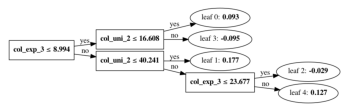

In [28]:
lgb.plot_tree(model, tree_index=1)

In [ ]:
tree_ix = 7
inspect_Tree = rf.estimators_[tree_ix]

used_columns = [features[ix] for ix in np.unique(inspect_Tree.tree_.feature) if ix>=0]

print(used_columns)

fig, ax = plt.subplots(figsize=(12,8))
dummy = plot_tree(inspect_Tree)

In [ ]:
train_leaf = model.predict(X_train,pred_leaf=True)
test_leaf = model.predict(X_test,pred_leaf=True)
oot_leaf = model.predict(X_oot,pred_leaf=True)

train_leaf = pd.DataFrame(train_leaf,columns = [f'tree_{i}' for i in range(test_leaf.shape[1])], index = X_train.index)
test_leaf = pd.DataFrame(test_leaf,columns = [f'tree_{i}' for i in range(test_leaf.shape[1])],  index = X_trX_testain.index)
oot_leaf = pd.DataFrame(oot_leaf,columns = [f'tree_{i}' for i in range(test_leaf.shape[1])], )

In [ ]:
train_leaf['tree_0'].value_counts(normalize=True)

In [ ]:
from probatus.sample_similarity import SHAPImportanceResemblance

model_res = lgb.LGBMClassifier(
    num_leaves=10,
    n_estimators=1000,
    min_child_samples=min_frac,
    learning_rate=0.1
)

rm = SHAPImportanceResemblance(model_res)
feature_importance, train_auc, test_auc = rm.fit_compute(X_train, X_oot, column_names=features, return_scores=True)

display(feature_importance)
test_auc

In [ ]:
test_auc

In [ ]:
train_leaf = model.predict(X_train,pred_leaf=True)
test_leaf = model.predict(X_test,pred_leaf=True)
oot_leaf = model.predict(X_oot,pred_leaf=True)

train_leaf = pd.DataFrame(train_leaf,columns = [f'tree_{i}' for i in range(test_leaf.shape[1])])
test_leaf = pd.DataFrame(test_leaf,columns = [f'tree_{i}' for i in range(test_leaf.shape[1])])
oot_leaf = pd.DataFrame(oot_leaf,columns = [f'tree_{i}' for i in range(test_leaf.shape[1])])

In [ ]:
train_leaf.shape

In [ ]:
n_tree = 18
train_test_psi = psi(train_leaf,test_leaf,f'tree_{n_tree}')
train_oot_psi = psi(train_leaf,oot_leaf,f'tree_{n_tree}')
print(train_test_psi, train_oot_psi)

In [ ]:
psis = list()
for i in range(train_leaf.shape[1]):
    psis.append(psi(train_leaf,oot_leaf,f'tree_{i}'))
    
plt.plot(psis)

In [ ]:
train_leaf_y_0 = train_leaf[y_train.reset_index()['y']==0]
oot_leaf_y_0 = oot_leaf[y_oot.reset_index()['y']==0]

train_leaf_y_1 = train_leaf[y_train.reset_index()['y']==1]
oot_leaf_y_1 = oot_leaf[y_oot.reset_index()['y']==1]

In [ ]:
psis = list()
for i in range(train_leaf.shape[1]):
    psis.append(psi(train_leaf_y_0,oot_leaf_y_0,f'tree_{i}'))
    
plt.plot(psis)

In [ ]:
psis = list()
for i in range(train_leaf.shape[1]):
    psis.append(psi(train_leaf_y_1,oot_leaf_y_1,f'tree_{i}'))
    
plt.plot(psis)

# Test here a shift

In [ ]:
make_copy = lambda x: x.copy()

cols_to_shift = [
    col for col in data.columns
    if col.endswith("_3") or col.endswith("_4")
]
print(cols_to_shift)

data = (
    data_raw
    .pipe(make_copy)
    .pipe(shift_features, cols_to_shift = data.columns, min_max_scaler_range=(1,100))
)

data_shift = (
    data_raw
    .pipe(make_copy)
    .pipe(shift_features, cols_to_shift = data.columns, min_max_scaler_range=(1,100))
    .pipe(shift_features, cols_to_shift = cols_to_shift, min_max_scaler_range=(21,120))
)

In [ ]:
data_shift.min()

In [ ]:
fig, ax = plt.subplots(3,5, figsize=(15,10))

for ix,col in enumerate([col for col in data.columns if "time" not in col]):
    ix_horiz = ix%5
    ix_vert = int(ix/5)                  
    data[col].hist(bins=40,alpha=0.4, ax = ax[ix_vert][ix_horiz])
    data_shift[col].hist(bins=40,alpha=0.4, ax = ax[ix_vert][ix_horiz])
    ax[ix_vert][ix_horiz].set_title(col)

# Check the shifts

# Make the score relationships

In [ ]:
interaction_terms = "".join([
    "2.5*col_exp_2*col_exp_3",
    "-0.2*col_uni_2*col_uni_3",
    "+0.7*col_norm_2*col_norm_3",
    
    "+0.8*col_norm_2*col_uni_3", #
    "-1.3*col_uni_2/col_exp_3", # the shift shoul reduce here the effect  
])
interaction_terms

In [ ]:
# expressions = {
#     'linear': '-0.5*col_exp_0 + 0.3*col_uni_0 -0.2*col_norm_0',
#     'non_linear': '-0.7*col_exp_2**1.5 + 0.2*sin(col_norm_2)+ 0.9*log(col_uni_2)',
#     'interaction': interaction_terms,
#     'conditional': {
#         'col_uni_4>0':(
#             '-0.5*col_exp_0 + 2.*col_uni_4 + 0.7*col_norm_3 -0.4*col_exp_1', #True
#             0 #False
#         ),
#         'col_uni_3>0.15':(
#             '-0.5*col_norm_0 + 2.*col_uni_4 + 0.2*col_uni_3 -0.7*col_norm_2',#True
#             '-0.5*col_exp_2' #False
#         )
#     },
#     'uniform_noise': {
#         'weight':3.7
#     },
#     'gaussian_noise': {
#         'weight':5.4,
#         'mu_gaus': -1.5
#     }
# }

In [ ]:
expressions = {
    'linear': '-0.5*col_exp_0 + 0.3*col_uni_0 -0.2*col_norm_0',
    'non_linear': '0.7*col_exp_2**1.5 - 0.2*sin(col_norm_2)- 0.9*log(col_uni_2)',
    'interaction': interaction_terms,
        'conditional': {
        'col_uni_4>0':(
            0, #True
            0 #False
        )},
#     'conditional': {
#         'col_uni_4>0':(
#             '-0.5*col_exp_0 + 2.*col_uni_4 + 0.7*col_norm_3 -0.4*col_exp_1', #True
#             0 #False
#         ),
#         'col_uni_3>0.15':(
#             '-0.5*col_norm_0 + 2.*col_uni_4 + 0.2*col_uni_3 -0.7*col_norm_2',#True
#             '-0.5*col_exp_2' #False
#         )
#     },
    'uniform_noise': {
        'weight':3.7
    },
    'gaussian_noise': {
        'weight':5.4,
        'mu_gaus': -1.5
    }
}

In [ ]:
tmp = target.get_target_and_contributions(data, expressions=expressions, imbalance = 0.1)
tmp_shift = target.get_target_and_contributions(data_shift, expressions=expressions, imbalance = 0.1)

In [ ]:
tmp.head()

In [ ]:
from sklearn.metrics import roc_auc_score

print(f"Linear component: {roc_auc_score(tmp['y'],tmp['score_linear'])}")
print(f"Non Linear component: {roc_auc_score(tmp['y'],tmp['score_non_linear'])}")
print(f"Interaction component: {roc_auc_score(tmp['y'],tmp['score_interaction'])}")
print(f"Conditional component: {roc_auc_score(tmp['y'],tmp['score_conditional'])}")
print(f"Total component: {roc_auc_score(tmp['y'],tmp['score_linear'] + tmp['score_non_linear'] + tmp['score_interaction'] + tmp['score_conditional'])}")
# print(f"Total component: {roc_auc_score(tmp['y'],tmp['score_linear'] + tmp['score_non_linear'] + tmp['score_interaction'])}")

In [ ]:
tmp.shape, tmp_shift.shape

In [ ]:
y = tmp['y']


### Let's keep it simple: make a Random Forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[features],y, test_size=0.25, random_state=42)

In [ ]:
X_test_ix = X_test.index

X_shift_test = data_shift[features].iloc[X_test_ix]
y_shift_test = y_test

In [ ]:
y_train.value_counts()

In [ ]:
rf = RandomForestClassifier(n_estimators=10,max_leaf_nodes=6, random_state=42, bootstrap=False).fit(X_train, y_train)

In [ ]:
print(f"Train distribution {roc_auc_score(y_train,rf.predict_proba(X_train)[:,1])}")
print(f"Test distribution {roc_auc_score(y_test,rf.predict_proba(X_test)[:,1])}")
print(f"Shifted Test distribution {roc_auc_score(y_test,rf.predict_proba(X_shift_test)[:,1])}")

In [ ]:
feat_imp = pd.Series(rf.feature_importances_, index = features).sort_values(ascending=False)

In [ ]:
def calculate_pred_per_tree(rf_model, X,y):
        
    leaves,mapping, columns = compute_leaves(rf_model, X,y)
        
    preds = pd.concat([
        leaves[col].map(mapping[col]) for col in columns
    ], 
        axis =1)
    
    return preds

def compute_leaves(rf_model, X,y=None):
    leaves = rf_model.apply(X)
        
    columns = [f'tree_{i}' for i in range(leaves.shape[1])]
    
    leaves = pd.DataFrame(leaves,columns = columns, index = X.index)
    
    mapping = dict()
    
    if y is not None:
        leaves['y'] = y
        for col in columns:
            mapping[col] = leaves.groupby(col)['y'].mean().to_dict()
            
    return leaves,mapping, columns

class MyRF(RandomForestClassifier):
    
    def __init__(self,fitted_model):
        
        self.model = fitted_model
        self.estimators_ = fitted_model.estimators_
        self.criterion = fitted_model.criterion
    
    def fit(self, X,y):
        
        self._fit_columns = X.columns
        
        self.leaves, self.mapping, self.columns = compute_leaves(self.model,X,y)

        return self
        
    def predict_proba(self,X):
        
        assert (X.columns == self._fit_columns).all(), f"Shape of X is wrong: Expected {len(self.columns)}, got { len(X.columns)}"
        
        leaves, *dummy = compute_leaves(self.model,X,y=None)
        
        preds = pd.concat([
            leaves[col].map(self.mapping[col]) for col in self.columns
        ], axis =1)
        
        preds_1 = preds.mean(axis=1).values
        
        out = np.array([[p0, p1] for p0,p1 in zip(1-preds_1, preds_1)])
        
        return out
                
        

In [ ]:
myrf = MyRF(rf).fit(X_train,y_train)
    

In [ ]:
np.testing.assert_almost_equal(myrf.predict_proba(X_train)[:,1] , rf.predict_proba(X_train)[:,1])

In [ ]:
preds_train = calculate_pred_per_tree(rf, X_train, y_train)
preds_test = calculate_pred_per_tree(rf, X_test, y_test)
preds_shift_test = calculate_pred_per_tree(rf, X_shift_test, y_test)

In [ ]:
fig, ax = plt.subplots(5,2, figsize=(10,15))
dummy = (preds_shift_test - preds_test).hist(ax=ax)

In [ ]:
print(interaction_terms)

In [ ]:
tree_ix = 1
inspect_Tree = rf.estimators_[tree_ix]

used_columns = [features[ix] for ix in np.unique(inspect_Tree.tree_.feature) if ix>=0]

used_columns

In [ ]:
feat_imp

In [ ]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(15,10))
plot_tree(inspect_Tree)

# test resemblance model

In [ ]:
rf_rm = RandomForestClassifier(n_estimators=10,max_leaf_nodes=6, random_state=42, bootstrap=False)

In [ ]:
rm_std = SHAPImportanceResemblance(rf_rm)
feature_importance_std, train_auc_std, test_auc_std = rm_std.fit_compute(X_train, X_shift_test, column_names=features, return_scores=True)
test_auc_std

In [ ]:
feat_imp

In [ ]:
feature_importance_std

In [ ]:
rm_std.plot(plot_type="violin")

In [ ]:
myrf = MyRF(rf)

rm_manual = SHAPImportanceResemblance(myrf)
feature_importance, train_auc, test_auc = rm_manual.fit_compute(X_train, X_shift_test, column_names=features, return_scores=True)
test_auc

In [ ]:
feature_importance

In [ ]:
rm_std.plot(plot_type="violin")

In [ ]:
preds = calculate_pred_per_tree(rf, X_train,y_train)
preds

In [ ]:
(preds.mean(axis=1).values - model_pred).mean()

In [ ]:
col = "tree_0"

pd.concat(tmp_df[col].map(map_[col]))
tmp_df[col].map(map_[col])

In [ ]:
tmp_df.groupby('tree_1')['y'].mean().to_dict()

In [ ]:


# fig, ax = plt.subplots(figsize=(18,16))

# tree_out = tree.plot_tree(rf.estimators_[0], ax =ax)  

In [ ]:
pd.DataFrame(rf.apply(X_train))

In [ ]:
nodes = pd.Series(rf.apply(X_train).ravel(), index = X_train.index, name="nodes")

In [ ]:
tmp_1 = pd.concat([nodes,y_train], axis=1)

In [ ]:
tmp_1.groupby('nodes')["y"].mean().sort_values()

In [ ]:
tmp_1['nodes'].value_counts()

In [ ]:
first_tree = rf.estimators_[0].tree_

In [ ]:
first_tree.children_left<0

In [ ]:
first_tree.impurity

In [ ]:
tree_out[2]

In [ ]:
tree_out[first_tree.tree_.children_left<0]

In [ ]:
die here

In [ ]:
y_train.index

In [ ]:
# tmp['score_predictive'].describe()

In [ ]:
# tmp_shift['score_predictive'].describe()

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(tmp['y'],tmp['score_predictive'])

In [ ]:
roc_auc_score(tmp['y'],tmp['score_linear'])

In [ ]:
tmp['y'].value_counts()

In [ ]:
fig, ax = plt.subplots()

tmp_shift['score_predictive'].hist(ax=ax, bins=15,alpha = 0.4,color='red')
tmp['score_predictive'].hist(ax=ax, bins=10,alpha = 0.4, color='blue')

ax.set_xlim(-10,10)

### Fit a model on the data

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, tmp['y'], test_size=0.25, random_state=42)

min_frac =int(0.05*X_train.shape[0])
min_frac

model = lgb.LGBMClassifier(
    num_leaves=16,
    n_estimators=300,
    min_child_samples=min_frac
)

%%time
eval_set = [(X_train,y_train),(X_test, y_test)]

model.fit(
    X_train,
    y_train,
    eval_metric=["auc",'aucpr'], 
    eval_set=eval_set, 
    verbose=30, # after how many training sets you want the printout on the console
    early_stopping_rounds=10
)

fig, ax = plt.subplots(1,2,figsize=(13,8))

ax[0].plot(model.evals_result_['training']['binary_logloss'])
ax[0].plot(model.evals_result_['valid_1']['binary_logloss'])

ax[1].plot(model.evals_result_['training']['auc'])
ax[1].plot(model.evals_result_['valid_1']['auc'])

train_leaf = model.predict(X_train,pred_leaf=True)
test_leaf = model.predict(X_test,pred_leaf=True)
shift_leaf = model.predict(X_shift,pred_leaf=True)

train_leaf = pd.DataFrame(train_leaf,columns = [f'tree_{i}' for i in range(test_leaf.shape[1])])
test_leaf = pd.DataFrame(test_leaf,columns = [f'tree_{i}' for i in range(test_leaf.shape[1])])
shift_leaf = pd.DataFrame(shift_leaf,columns = [f'tree_{i}' for i in range(test_leaf.shape[1])])

In [ ]:
X_shift = data_shift.values

In [ ]:
model.evals_result_['training'].keys()

In [ ]:
X_train.shape

In [ ]:
train_leaf.shape

In [ ]:
train_leaf.head()

In [ ]:
n_tree = 980
train_test_psi = psi(train_leaf,test_leaf,f'tree_{n_tree}')
train_shift_psi = psi(train_leaf,shift_leaf,f'tree_{n_tree}')
train_test_psi, train_shift_psi

psis = list()
for i in range(train_leaf.shape[1]):
    psis.append(psi(train_leaf,shift_leaf,f'tree_{i}'))
    
plt.plot(psis)